<a href="https://colab.research.google.com/github/liisipan/NetworkScience/blob/master/Project_in_Network_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font color='black'>  Community-level decision making: the Wikipedia requests for adminship </font></center></h1>
<h3><center><font color='black'> Project in Network Science (LTAT.02.011) </font></center></h3>
<h3><center><font color='black'> University of Tartu </font></center></h3>
<h3><center><font color='black'><b> Liisi Panov </font></center></h3>

================================================================================================================

In [ ]:
!pip install igraph
!pip install python-igraph==0.8.3
!apt install libcairo2-dev pkg-config python3-dev
!pip install python-igraph leidenalg cairocffi
!pip install stellargraph

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
import networkx as nx
import stellargraph as sg

from collections import namedtuple

from networkx.algorithms import community

import community.community_louvain as community_louvain

from stellargraph import StellarDiGraph, globalvar
from stellargraph.layer import GCN, GraphSAGE
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping

from IPython.display import display, HTML

from collections import Counter

##### Create a dataframe from raw data

In [ ]:
#Read in the raw data and have a look at some of the first lines
file = open('wiki-RfA.txt', 'r')
lines = file.readlines()
file.close()

for line in lines[0:30]:
    print(line.strip())

SRC:Steel1943
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:13, 19 April 2013
TXT:'''Support''' as co-nom.

SRC:Cuchullain
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:01:04, 20 April 2013
TXT:'''Support''' as nominator.--

SRC:INeverCry
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:43, 19 April 2013
TXT:'''Support''' per noms.

SRC:Cncmaster
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:00:11, 20 April 2013


In [ ]:
# Create a dataframe from the raw dataset
Item = namedtuple('item', 'source target vote result year date comment')
items = []

with open('wiki-RfA.txt', 'r') as file: 
    for line in file:
        l = line.rstrip('\n')
        
        if l.startswith('SRC:'):
          source = l[4:]
        elif l.startswith('TGT:'):
          target = l[4:]
        elif l.startswith('VOT:'):
          vote = l[4:]
        elif l.startswith('RES:'):
          result = l[4:]
        elif l.startswith('YEA:'):
          year = l[4:]
        elif l.startswith('DAT:'):
          date = l[4:]
        elif l.startswith('TXT'):
          comment = l[4:]

          item = Item(source, target, vote, result, year, date, comment)
          items.append(item)

wikipedia_data = pd.DataFrame.from_records(items, columns=item._fields)

In [ ]:
wikipedia_data.shape

(198275, 7)

In [ ]:
wikipedia_data.dtypes

source     object
target     object
vote       object
result     object
year       object
date       object
comment    object
dtype: object

##### Data preprocessing



In [ ]:
wikipedia_data['vote'] = wikipedia_data['vote'].astype(int)
wikipedia_data['result'] = wikipedia_data['result'].astype(int)
wikipedia_data['year'] = wikipedia_data['year'].astype(int)

In [ ]:
np.unique(wikipedia_data['vote'], return_counts=True)

(array([-1,  0,  1]), array([ 41176,  12648, 144451]))

In [ ]:
#drop neutral votes as these do not convey meaning
wikipedia_data.drop(wikipedia_data[wikipedia_data['vote'] == 0].index, inplace = True)
wikipedia_data.shape

(185627, 7)

In [ ]:
#drop rows were source or target is missing
wikipedia_data.drop(wikipedia_data[wikipedia_data['source'] == ""].index.union(wikipedia_data[wikipedia_data['target'] == ""].index), inplace=True)
wikipedia_data.shape

(184546, 7)

In [ ]:
#drop duplicated rows
wikipedia_data.drop_duplicates(keep='first', inplace=True, ignore_index=True)
wikipedia_data.shape

(184541, 7)

In [ ]:
#drop rows where source and target are the same
wikipedia_data.drop(wikipedia_data[wikipedia_data['source'] == wikipedia_data['target']].index, inplace = True)
wikipedia_data.shape

(184454, 7)

In [ ]:
#voting date from string to date format, also some corrections
wikipedia_data['date'] = wikipedia_data['date'].replace(['14:47, 1 Julu 2012'],'14:47, 1 July 2012')
wikipedia_data['date'] = wikipedia_data['date'].replace(['31:29, 24 May 2008'],'00:00, 24 May 2008')
wikipedia_data['date'] = wikipedia_data['date'].replace(['17:44, 26 Mya 2007'],'17:44, 26 May 2007')

wikipedia_data['date_as_date'] = pd.to_datetime(wikipedia_data['date'])

In [ ]:
wikipedia_data = wikipedia_data.rename(columns={"date": "date_orig", "date_as_date": "date"})

In [ ]:
wikipedia_data

,source,target,vote,result,year,date_orig,comment,date
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,2013-04-19 23:13:00
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,2013-04-20 01:04:00
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,2013-04-19 23:43:00
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,2013-04-20 00:11:00
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",2013-04-20 00:56:00
...,...,...,...,...,...,...,...,...
184536,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,2003-09-02 02:51:00
184537,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,2003-11-26 23:45:00
184538,Jiang,WhisperToMe,1,1,2003,,Support. --,NaT
184539,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,2003-12-05 05:38:00


##### Exploring the data

In [ ]:
#votes by year
np.transpose(np.unique(wikipedia_data['year'], return_counts=True))

array([[ 2003,   198],
       [ 2004,  6184],
       [ 2005, 19144],
       [ 2006, 41470],
       [ 2007, 38923],
       [ 2008, 28345],
       [ 2009, 19837],
       [ 2010, 12929],
       [ 2011,  8043],
       [ 2012,  6039],
       [ 2013,  3342]])

In [ ]:
#distribution of negative and positive votes
vote_counts = np.unique(wikipedia_data['vote'], return_counts=True)

neg_votes = round(vote_counts[1][0]/wikipedia_data.shape[0], 1)
pos_votes = round(vote_counts[1][1]/wikipedia_data.shape[0], 1)

print('The percentage of negative votes is', neg_votes*100, 'and positive votes is', pos_votes*100)

The percentage of negative votes is 20.0 and positive votes is 80.0


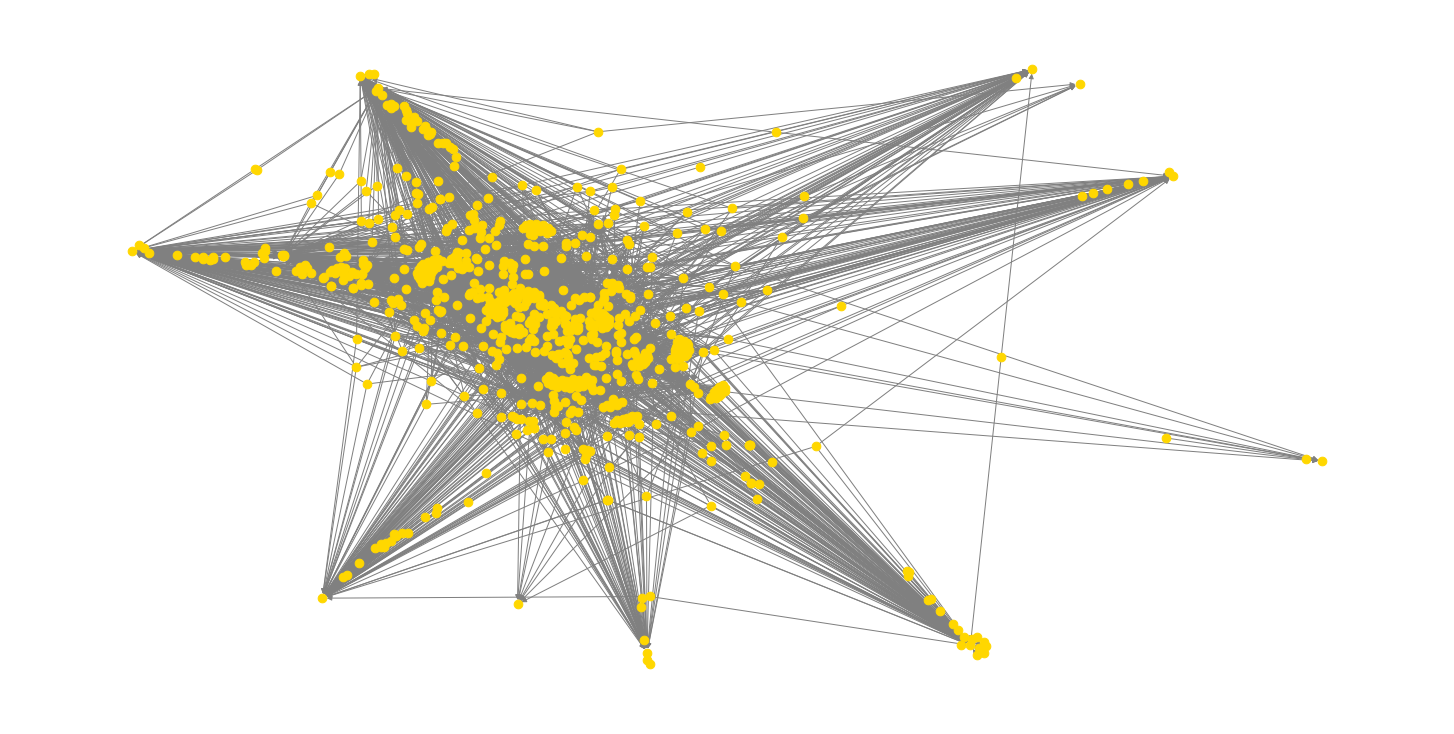

In [ ]:
#just for illustrative purposes - network of votes given in 2013
plt.figure(figsize=(20, 10))

wiki_data_2013 = wikipedia_data[wikipedia_data['year'] == 2013]
G = nx.from_pandas_edgelist(df=wiki_data_2013[['source', 'target']], source='source', target='target', create_using=nx.MultiDiGraph())

nx.draw(G, node_size=75, node_color="gold", edge_color='grey')

In [ ]:
#Network from the whole dataset
G = nx.from_pandas_edgelist(wikipedia_data, source='source', target='target', create_using=nx.MultiDiGraph())

nx.info(G)

'MultiDiGraph with 11256 nodes and 184454 edges'

In [ ]:
round(nx.density(G), 5)

0.00146

In [ ]:
round(nx.average_shortest_path_length(G), 3)

0.926

(array([8.223e+03, 8.790e+02, 5.870e+02, 4.190e+02, 3.120e+02, 2.330e+02,
        1.430e+02, 9.600e+01, 7.800e+01, 4.700e+01, 5.300e+01, 4.300e+01,
        1.800e+01, 1.900e+01, 1.300e+01, 1.700e+01, 1.300e+01, 1.200e+01,
        6.000e+00, 8.000e+00]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.,
        275., 300., 325., 350., 375., 400., 425., 450., 475., 500.]),
 <a list of 20 Patch objects>)

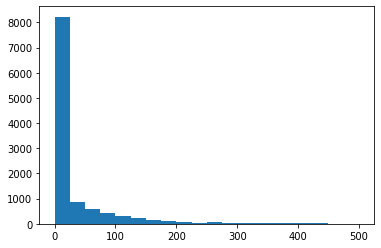

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]

plt.hist(degrees, range=(0, 500), bins=20)

In [ ]:
nx.is_strongly_connected(G)

False

In [ ]:
nx.number_strongly_connected_components(G)

8819

##### Users that have become Wikipedia administrators

In [ ]:
#who has become a Wikipedia admin
new_admins = wikipedia_data[['target', 'year', 'date']][wikipedia_data['result']==1]
new_admins.rename(columns = {'target':'user'}, inplace = True)

In [ ]:
new_admins = new_admins.sort_values(by=['user', 'date'], ascending=False)

In [ ]:
new_admins

,user,year,date
178173,Ævar Arnfjörð Bjarmason,2004,2004-05-20 18:30:00
178178,Ævar Arnfjörð Bjarmason,2004,2004-05-20 06:07:00
178172,Ævar Arnfjörð Bjarmason,2004,2004-05-19 22:47:00
178171,Ævar Arnfjörð Bjarmason,2004,2004-05-19 21:41:00
178170,Ævar Arnfjörð Bjarmason,2004,2004-05-19 21:25:00
...,...,...,...
117508,(aeropagitica),2006,2006-02-28 01:11:00
117507,(aeropagitica),2006,2006-02-28 00:09:00
117519,(aeropagitica),2006,NaT
117524,(aeropagitica),2006,NaT


In [ ]:
new_admins.drop_duplicates(subset='user', keep='first', inplace=True, ignore_index=True)   #only the row with the latest voting time remains
new_admins.shape

(1899, 3)

In [ ]:
new_admins

,user,year,date
0,Ævar Arnfjörð Bjarmason,2004,2004-05-20 18:30:00
1,xDanielx,2007,2007-12-11 09:01:00
2,thedemonhog,2008,2008-07-06 23:44:00
3,theProject,2006,2006-06-30 01:13:00
4,the undertow,2007,2007-07-27 08:50:00
...,...,...,...
1894,2over0,2009,2009-11-26 17:52:00
1895,28bytes,2011,2011-06-14 10:05:00
1896,23skidoo,2005,2005-10-06 21:33:00
1897,168...,2003,2003-12-05 05:39:00


In [ ]:
new_admins_count = np.unique(new_admins['year'], return_counts=True)
np.transpose(new_admins_count)

array([[2003,   52],
       [2004,  230],
       [2005,  376],
       [2006,  346],
       [2007,  404],
       [2008,  198],
       [2009,  120],
       [2010,   74],
       [2011,   52],
       [2012,   28],
       [2013,   19]])

##### All candidates for Wikipedia adminship

In [ ]:
candidates = wikipedia_data[['target', 'year']]
candidates.rename(columns = {'target':'user'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
candidates.drop_duplicates(keep='first', inplace=True, ignore_index=True)
candidates.shape

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(3804, 2)

In [ ]:
candidates

,user,year
0,BDD,2013
1,Bilby,2013
2,Darkwind,2013
3,INeverCry,2013
4,Jason Quinn,2013
...,...,...
3799,Tristanb,2003
3800,Ugen64,2003
3801,Vancouverguy,2003
3802,WhisperToMe,2003


In [ ]:
candidates_count = np.unique(candidates['year'], return_counts=True)
np.transpose(candidates_count)

array([[2003,   55],
       [2004,  286],
       [2005,  543],
       [2006,  789],
       [2007,  819],
       [2008,  521],
       [2009,  317],
       [2010,  212],
       [2011,  134],
       [2012,   93],
       [2013,   35]])

In [ ]:
#proportion of successful candidates by year
successful_cand_perc = new_admins_count[1] / candidates_count[1]
successful_cand_perc = successful_cand_perc.round(2)
successful_cand_perc

array([0.95, 0.8 , 0.69, 0.44, 0.49, 0.38, 0.38, 0.35, 0.39, 0.3 , 0.54])

In [ ]:
successful_cand = pd.DataFrame({'year': range(2003, 2014), 'candidates': candidates_count[1], 'new_admins': new_admins_count[1], 'ratio': successful_cand_perc})
successful_cand

,year,candidates,new_admins,ratio
0,2003,55,52,0.95
1,2004,286,230,0.80
2,2005,543,376,0.69
3,2006,789,346,0.44
4,2007,819,404,0.49
5,2008,521,198,0.38
6,2009,317,120,0.38
7,2010,212,74,0.35
8,2011,134,52,0.39
9,2012,93,28,0.30


#### **Voting coherence of admins before and after becoming an admin**



In [ ]:
all_admin_votes = wikipedia_data[wikipedia_data['source'].isin(list(new_admins['user']))]   #all the votes that new admins have given

In [ ]:
all_admin_votes.sort_values(by=['source'])

,source,target,vote,result,year,date_orig,comment,date
131819,(aeropagitica),Luna Santin,1,1,2006,"13:25, 3 September 2006",'''Support''' Helps new users; reports and rev...,2006-09-03 13:25:00
90905,(aeropagitica),Jogers,1,1,2007,"21:50, 9 September 2007",'''Support''' I can't see a problem with this ...,2007-09-09 21:50:00
121977,(aeropagitica),ChrisGriswold,1,1,2006,"21:10, 9 October 2006",'''Edit-conflict Support''' Looks like a good ...,2006-10-09 21:10:00
157829,(aeropagitica),Trysha,1,-1,2006,"05:38, 5 October 2006","'''Support''' Seems like a good candidate, ple...",2006-10-05 05:38:00
109195,(aeropagitica),Hdt83,-1,-1,2007,"04:40, 3 August 2007",'''Oppose''' Needs to heed the advice from the...,2007-08-03 04:40:00
...,...,...,...,...,...,...,...,...
66509,thedemonhog,Xavexgoem,1,1,2008,"17:07, 13 June 2008",I do not have a problem with someone who is no...,2008-06-13 17:07:00
180428,Ævar Arnfjörð Bjarmason,Jerzy,1,1,2004,,--,NaT
179197,Ævar Arnfjörð Bjarmason,Diberri,1,1,2004,,,NaT
179737,Ævar Arnfjörð Bjarmason,Fredrik,1,1,2004,,--,NaT


In [ ]:
len(set(new_admins['user']))

1899

In [ ]:
len(set(all_admin_votes['source']))   #some of the new admins have not voted even once after becoming an admin

1694

In [ ]:
all_admin_votes = all_admin_votes.join(new_admins.set_index('user'), on='source', lsuffix='_voting', rsuffix='_admin')   #adding the date of last vote for becoming an admin
all_admin_votes.sort_values(by=['source'])

,source,target,vote,result,year_voting,date_orig,comment,date_voting,year_admin,date_admin
131819,(aeropagitica),Luna Santin,1,1,2006,"13:25, 3 September 2006",'''Support''' Helps new users; reports and rev...,2006-09-03 13:25:00,2006,2006-03-06 22:36:00
90905,(aeropagitica),Jogers,1,1,2007,"21:50, 9 September 2007",'''Support''' I can't see a problem with this ...,2007-09-09 21:50:00,2006,2006-03-06 22:36:00
121977,(aeropagitica),ChrisGriswold,1,1,2006,"21:10, 9 October 2006",'''Edit-conflict Support''' Looks like a good ...,2006-10-09 21:10:00,2006,2006-03-06 22:36:00
157829,(aeropagitica),Trysha,1,-1,2006,"05:38, 5 October 2006","'''Support''' Seems like a good candidate, ple...",2006-10-05 05:38:00,2006,2006-03-06 22:36:00
109195,(aeropagitica),Hdt83,-1,-1,2007,"04:40, 3 August 2007",'''Oppose''' Needs to heed the advice from the...,2007-08-03 04:40:00,2006,2006-03-06 22:36:00
...,...,...,...,...,...,...,...,...,...,...
66509,thedemonhog,Xavexgoem,1,1,2008,"17:07, 13 June 2008",I do not have a problem with someone who is no...,2008-06-13 17:07:00,2008,2008-07-06 23:44:00
180428,Ævar Arnfjörð Bjarmason,Jerzy,1,1,2004,,--,NaT,2004,2004-05-20 18:30:00
179197,Ævar Arnfjörð Bjarmason,Diberri,1,1,2004,,,NaT,2004,2004-05-20 18:30:00
179737,Ævar Arnfjörð Bjarmason,Fredrik,1,1,2004,,--,NaT,2004,2004-05-20 18:30:00


##### Admin votes before becoming an admin

In [ ]:
admin_votes_before = all_admin_votes[all_admin_votes['date_voting'] < all_admin_votes['date_admin']]   #all the votes that new admins have given before becoming an admin

In [ ]:
#aggregate votes given by admins before becoming an admin
admin_votes_before = admin_votes_before.groupby(by=['target', 'result', 'vote'], sort=False)['vote'].agg(['count']).reset_index()

In [ ]:
admin_votes_before

,target,result,vote,count
0,BDD,1,1,1
1,Darkwind,1,1,4
2,INeverCry,1,1,3
3,Jason Quinn,1,1,3
4,Jason Quinn,1,-1,2
...,...,...,...,...
4474,Yelyos,-1,-1,1
4475,168...,1,1,2
4476,Dieter Simon,1,1,1
4477,Secretlondon,1,1,1


In [ ]:
admin_votes_before = pd.pivot(admin_votes_before, index=('target', 'result'), columns='vote', values='count')

admin_votes_before.reset_index(inplace=True)

admin_votes_before.rename(columns = {-1:'neg_votes', 1:'pos_votes'}, inplace = True)

admin_votes_before['neg_votes'] = admin_votes_before['neg_votes'].fillna(0)
admin_votes_before['neg_votes'] = admin_votes_before['neg_votes'].astype(int)

admin_votes_before['pos_votes'] = admin_votes_before['pos_votes'].fillna(0)
admin_votes_before['pos_votes'] = admin_votes_before['pos_votes'].astype(int)

admin_votes_before['votes'] = admin_votes_before['neg_votes'] + admin_votes_before['pos_votes']
admin_votes_before['neg_votes_perc'] = round(admin_votes_before['neg_votes']/admin_votes_before['votes'], 2)*100
admin_votes_before['pos_votes_perc'] = round(admin_votes_before['pos_votes']/admin_votes_before['votes'], 2)*100

In [ ]:
admin_votes_before.drop(admin_votes_before[admin_votes_before['votes'] < 10].index, inplace = True)   #leave out votings which have less than 10 votes from admins

In [ ]:
admin_votes_before

vote,target,result,neg_votes,pos_votes,votes,neg_votes_perc,pos_votes_perc
0,(aeropagitica),1,3,13,16,19.0,81.0
5,23skidoo,1,0,16,16,0.0,100.0
8,2over0,1,0,11,11,0.0,100.0
10,5 albert square,1,0,10,10,0.0,100.0
14,7,1,0,14,14,0.0,100.0
...,...,...,...,...,...,...,...
3318,monotonehell,1,2,8,10,20.0,80.0
3339,the undertow,1,0,17,17,0.0,100.0
3340,theProject,1,0,15,15,0.0,100.0
3343,tjstrf,-1,0,14,14,0.0,100.0


Text(0, 0.5, 'density')

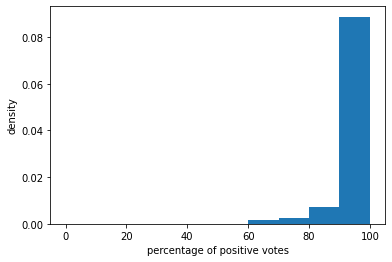

In [ ]:
plt.hist(admin_votes_before['pos_votes_perc'][admin_votes_before['result']==1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of positive votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

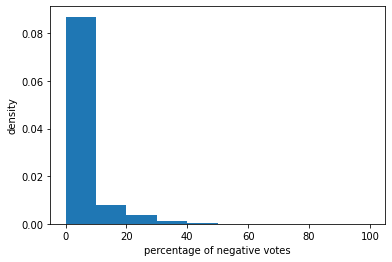

In [ ]:
plt.hist(admin_votes_before['neg_votes_perc'][admin_votes_before['result']==1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of negative votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

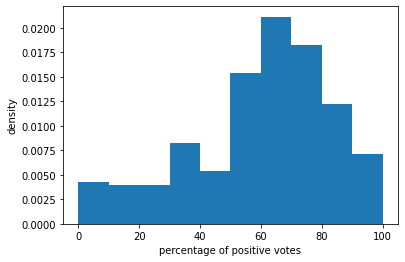

In [ ]:
plt.hist(admin_votes_before['pos_votes_perc'][admin_votes_before['result']==-1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of positive votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

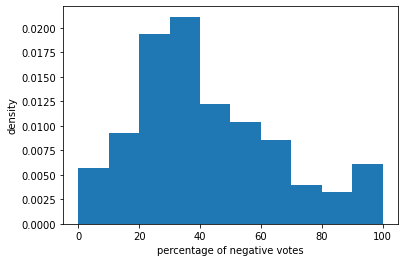

In [ ]:
plt.hist(admin_votes_before['neg_votes_perc'][admin_votes_before['result']==-1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of negative votes")
plt.ylabel("density")

##### Admin votes after becoming an admin

In [ ]:
admin_votes_after = all_admin_votes[all_admin_votes['date_voting'] >= all_admin_votes['date_admin']]   #all the votes that new admins have given after becoming an admin

In [ ]:
admin_votes_after.sort_values(by=['target', 'source'])

,source,target,vote,result,year_voting,date_orig,comment,date_voting,year_admin,date_admin
117530,BD2412,(aeropagitica),1,1,2006,"03:14, 2 March 2006",'''Support'''.,2006-03-02 03:14:00,2005,2005-12-19 00:42:00
117507,Dbiv,(aeropagitica),1,1,2006,"00:09, 28 February 2006","'''Support'''. Yippee, I get to be the first!",2006-02-28 00:09:00,2005,2005-01-20 00:11:00
117515,Essexmutant,(aeropagitica),1,1,2006,"14:43, 28 February 2006","'''Support''', meets my standards. No reason t...",2006-02-28 14:43:00,2006,2006-02-13 15:55:00
117550,Geogre,(aeropagitica),-1,1,2006,"11:18, 28 February 2006",'''Weakly''' oppose on the basis of time on pr...,2006-02-28 11:18:00,2004,2004-08-13 13:11:00
117544,JIP,(aeropagitica),1,1,2006,"21:15, 5 March 2006",'''Extra support with knobs on'''. I've had a ...,2006-03-05 21:15:00,2005,2005-09-09 15:37:00
...,...,...,...,...,...,...,...,...,...,...
173987,JIP,Ђорђе Д. Божовић,-1,-1,2005,"15:23, 27 November 2005",'''Oppose'''. I'm sure Djordje (I can't type h...,2005-11-27 15:23:00,2005,2005-09-09 15:37:00
173980,Jkelly,Ђорђе Д. Божовић,-1,-1,2005,"02:41, 26 November 2005","'''Oppose''', in spite of the fact that I am a...",2005-11-26 02:41:00,2005,2005-11-25 03:36:00
173978,Karmafist,Ђорђе Д. Божовић,-1,-1,2005,"02:21, 26 November 2005",'''Oppose''': Becuase I normally vote against ...,2005-11-26 02:21:00,2005,2005-10-11 16:54:00
173985,Merovingian,Ђорђе Д. Божовић,-1,-1,2005,"10:10, 26 November 2005",'''Oppose''' for above reasons. --,2005-11-26 10:10:00,2004,2004-03-16 18:25:00


In [ ]:
#aggregate votes given by admins
admin_votes_after = admin_votes_after.groupby(by=['target', 'result', 'vote'], sort=False)['vote'].agg(['count']).reset_index()

In [ ]:
admin_votes_after

,target,result,vote,count
0,BDD,1,1,39
1,BDD,1,-1,1
2,Bilby,1,1,48
3,Darkwind,1,1,34
4,Darkwind,1,-1,9
...,...,...,...,...
5093,Snoyes,1,1,1
5094,Stan Shebs,1,1,2
5095,Sugarfish,1,1,1
5096,Timwi,1,1,1


In [ ]:
admin_votes_after = pd.pivot(admin_votes_after, index=('target', 'result'), columns='vote', values='count')

admin_votes_after.reset_index(inplace=True)

admin_votes_after.rename(columns = {-1:'neg_votes', 1:'pos_votes'}, inplace = True)

admin_votes_after['neg_votes'] = admin_votes_after['neg_votes'].fillna(0)
admin_votes_after['neg_votes'] = admin_votes_after['neg_votes'].astype(int)

admin_votes_after['pos_votes'] = admin_votes_after['pos_votes'].fillna(0)
admin_votes_after['pos_votes'] = admin_votes_after['pos_votes'].astype(int)

admin_votes_after['votes'] = admin_votes_after['neg_votes'] + admin_votes_after['pos_votes']
admin_votes_after['neg_votes_perc'] = round(admin_votes_after['neg_votes']/admin_votes_after['votes'], 2)*100
admin_votes_after['pos_votes_perc'] = round(admin_votes_after['pos_votes']/admin_votes_after['votes'], 2)*100

In [ ]:
admin_votes_after.drop(admin_votes_after[admin_votes_after['votes'] < 10].index, inplace = True)   #leave out votings which have less than 10 votes from admins

In [ ]:
admin_votes_after

vote,target,result,neg_votes,pos_votes,votes,neg_votes_perc,pos_votes_perc
0,(aeropagitica),1,2,11,13,15.0,85.0
2,21655,-1,12,0,12,100.0,0.0
3,23skidoo,1,0,23,23,0.0,100.0
4,28bytes,-1,6,13,19,32.0,68.0
5,28bytes,1,0,47,47,0.0,100.0
...,...,...,...,...,...,...,...
3510,thedemonhog,1,0,37,37,0.0,100.0
3512,tjstrf,-1,3,15,18,17.0,83.0
3515,xDanielx,1,5,23,28,18.0,82.0
3519,Ævar Arnfjörð Bjarmason,-1,12,19,31,39.0,61.0


Text(0, 0.5, 'density')

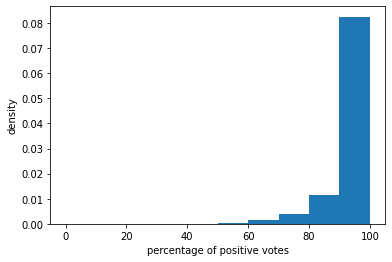

In [ ]:
plt.hist(admin_votes_after['pos_votes_perc'][admin_votes_after['result']==1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of positive votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

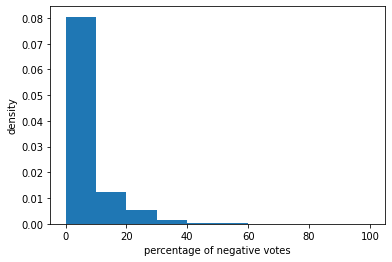

In [ ]:
plt.hist(admin_votes_after['neg_votes_perc'][admin_votes_after['result']==1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of negative votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

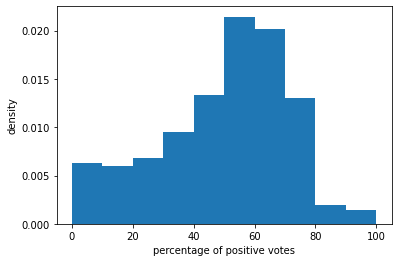

In [ ]:
plt.hist(admin_votes_after['pos_votes_perc'][admin_votes_after['result']==-1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of positive votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

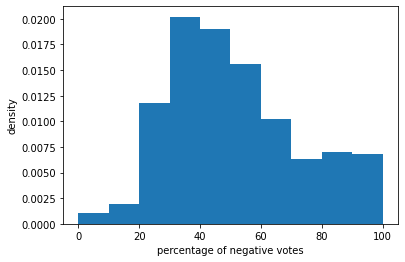

In [ ]:
plt.hist(admin_votes_after['neg_votes_perc'][admin_votes_after['result']==-1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of negative votes")
plt.ylabel("density")

#### **Voting coherence of unsuccessful candidates**

In [ ]:
unsuccessful_cand = set(candidates['user']) - set(new_admins['user'])

In [ ]:
len(unsuccessful_cand)

1590

In [ ]:
unsuccess_votes = wikipedia_data[wikipedia_data['source'].isin(list(unsuccessful_cand))]   #all the votes that unsuccessful candidates have given

In [ ]:
unsuccess_votes.sort_values(by=['source'])

,source,target,vote,result,year,date_orig,comment,date
22475,1234r00t,MGA73,1,1,2010,"21:31, 4 July 2010",'''Support''' as long as he's amicable to us t...,2010-07-04 21:31:00
29138,1234r00t,Richardcavell,-1,-1,2010,"23:43, 6 October 2010",'''Oppose''' per all the people that have said...,2010-10-06 23:43:00
21487,1234r00t,Jmh649,1,1,2010,"23:52, 19 August 2010",'''Support'''- User does not appear that he wo...,2010-08-19 23:52:00
20886,1234r00t,Grondemar,1,1,2010,"21:15, 29 December 2010",'''Support''' I don't think that the his behav...,2010-12-29 21:15:00
20481,1234r00t,Fetchcomms,1,1,2010,"00:10, 4 July 2010",'''Why Not'''- A good reason for almost anything.,2010-07-04 00:10:00
...,...,...,...,...,...,...,...,...
16253,Σ,Logan,1,-1,2011,"20:30, 14 May 2011","'''Support''', I don't see why not. --",2011-05-14 20:30:00
3724,Σ,Berean Hunter,1,1,2012,"02:18, 23 July 2012",This site will only benefit if he is given adm...,2012-07-23 02:18:00
15966,Σ,Guoguo12,1,-1,2011,"22:45, 19 June 2011","'''Support''' - It's time. --<span style=""text...",2011-06-19 22:45:00
15690,Σ,E2eamon,1,-1,2011,"06:04, 6 July 2011","'''Support''' - Good answers. --<span style=""t...",2011-07-06 06:04:00


In [ ]:
#aggregate votes given by unsuccessful candidates
unsuccess_votes = unsuccess_votes.groupby(by=['target', 'result', 'vote'], sort=False)['vote'].agg(['count']).reset_index()

In [ ]:
unsuccess_votes

,target,result,vote,count
0,BDD,1,1,12
1,BDD,1,-1,2
2,Bilby,1,1,11
3,Darkwind,1,1,10
4,Darkwind,1,-1,4
...,...,...,...,...
4732,Arwel Parry,1,1,1
4733,Bcorr,1,1,1
4734,Christopher Mahan,1,1,1
4735,Pakaran,1,1,1


In [ ]:
unsuccess_votes = pd.pivot(unsuccess_votes, index=('target', 'result'), columns='vote', values='count')

unsuccess_votes.reset_index(inplace=True)

unsuccess_votes.rename(columns = {-1:'neg_votes', 1:'pos_votes'}, inplace = True)

unsuccess_votes['neg_votes'] = unsuccess_votes['neg_votes'].fillna(0)
unsuccess_votes['neg_votes'] = unsuccess_votes['neg_votes'].astype(int)

unsuccess_votes['pos_votes'] = unsuccess_votes['pos_votes'].fillna(0)
unsuccess_votes['pos_votes'] = unsuccess_votes['pos_votes'].astype(int)

unsuccess_votes['votes'] = unsuccess_votes['neg_votes'] + unsuccess_votes['pos_votes']
unsuccess_votes['neg_votes_perc'] = round(unsuccess_votes['neg_votes']/unsuccess_votes['votes'], 2)*100
unsuccess_votes['pos_votes_perc'] = round(unsuccess_votes['pos_votes']/unsuccess_votes['votes'], 2)*100

In [ ]:
unsuccess_votes.drop(unsuccess_votes[unsuccess_votes['votes'] < 10].index, inplace = True)

In [ ]:
unsuccess_votes

vote,target,result,neg_votes,pos_votes,votes,neg_votes_perc,pos_votes_perc
4,28bytes,-1,4,6,10,40.0,60.0
5,28bytes,1,0,19,19,0.0,100.0
6,2over0,1,0,12,12,0.0,100.0
8,5 albert square,1,1,11,12,8.0,92.0
11,7,-1,6,10,16,38.0,62.0
...,...,...,...,...,...,...,...
3320,shoeofdeath,1,3,7,10,30.0,70.0
3323,theProject,1,0,11,11,0.0,100.0
3324,thedemonhog,1,1,12,13,8.0,92.0
3325,tjstrf,-1,2,10,12,17.0,83.0


Text(0, 0.5, 'density')

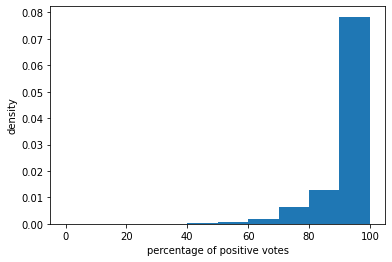

In [ ]:
plt.hist(unsuccess_votes['pos_votes_perc'][unsuccess_votes['result']==1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of positive votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

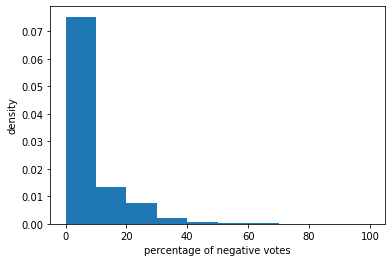

In [ ]:
plt.hist(unsuccess_votes['neg_votes_perc'][unsuccess_votes['result']==1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of negative votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

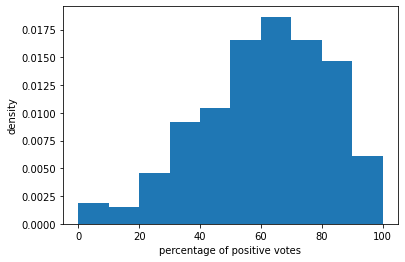

In [ ]:
plt.hist(unsuccess_votes['pos_votes_perc'][unsuccess_votes['result']==-1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of positive votes")
plt.ylabel("density")

Text(0, 0.5, 'density')

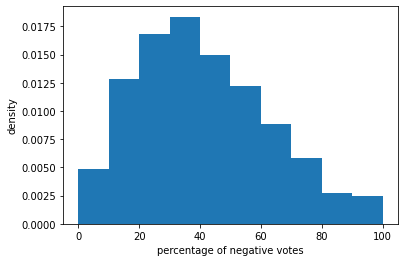

In [ ]:
plt.hist(unsuccess_votes['neg_votes_perc'][unsuccess_votes['result']==-1], bins=10, range=(0,100), density=True)
plt.xlabel("percentage of negative votes")
plt.ylabel("density")

#### **Grouping admins based on their voting tendencies**

In [ ]:
#all the votes new admins have given after becoming an admin; selecting only year 2003 for start
new_admins_2003 = all_admin_votes[all_admin_votes['date_voting'] >= all_admin_votes['date_admin']]
new_admins_2003 = new_admins_2003[new_admins_2003['year_voting'] == 2003]

In [ ]:
new_admins_2003.sort_values(by=['source', 'target'])

,source,target,vote,result,year_voting,date_orig,comment,date_voting,year_admin,date_admin
184368,Ark30inf,Arwel Parry,1,1,2003,"05:37, 10 Oct 2003",Support. Looks good.,2003-10-10 05:37:00,2003,2003-09-25 13:46:00
184390,Ark30inf,Daniel Quinlan,1,1,2003,"08:01, 21 Oct 2003",Support. --,2003-10-21 08:01:00,2003,2003-09-25 13:46:00
184513,Ark30inf,Stan Shebs,1,1,2003,"03:54, 2 Oct 2003",Support.,2003-10-02 03:54:00,2003,2003-09-25 13:46:00
184526,Ark30inf,Tristanb,1,1,2003,"04:54, 9 Oct 2003",Support.,2003-10-09 04:54:00,2003,2003-09-25 13:46:00
184428,Arwel Parry,Finlay McWalter,1,1,2003,"23:18, 14 Dec 2003",Support --,2003-12-14 23:18:00,2003,2003-10-10 14:21:00
184460,Arwel Parry,Morwen,1,1,2003,"22:57, 13 Nov 2003",Support. Sensible edits and corrections (and l...,2003-11-13 22:57:00,2003,2003-10-10 14:21:00
184484,Arwel Parry,Pakaran,1,1,2003,"16:13, 5 Dec 2003",Support. Seems a sensible contributor.,2003-12-05 16:13:00,2003,2003-10-10 14:21:00
184505,Arwel Parry,SimonP,1,1,2003,"23:18, 14 Dec 2003",Support --,2003-12-14 23:18:00,2003,2003-10-10 14:21:00
184417,Dysprosia,Evil saltine,1,1,2003,"03:07, 15 Oct 2003","Strong support, seen some excellent edits from...",2003-10-15 03:07:00,2003,2003-09-08 21:31:00
184423,Dysprosia,Finlay McWalter,1,1,2003,"03:40, 14 Dec 2003",Support from me :),2003-12-14 03:40:00,2003,2003-09-08 21:31:00


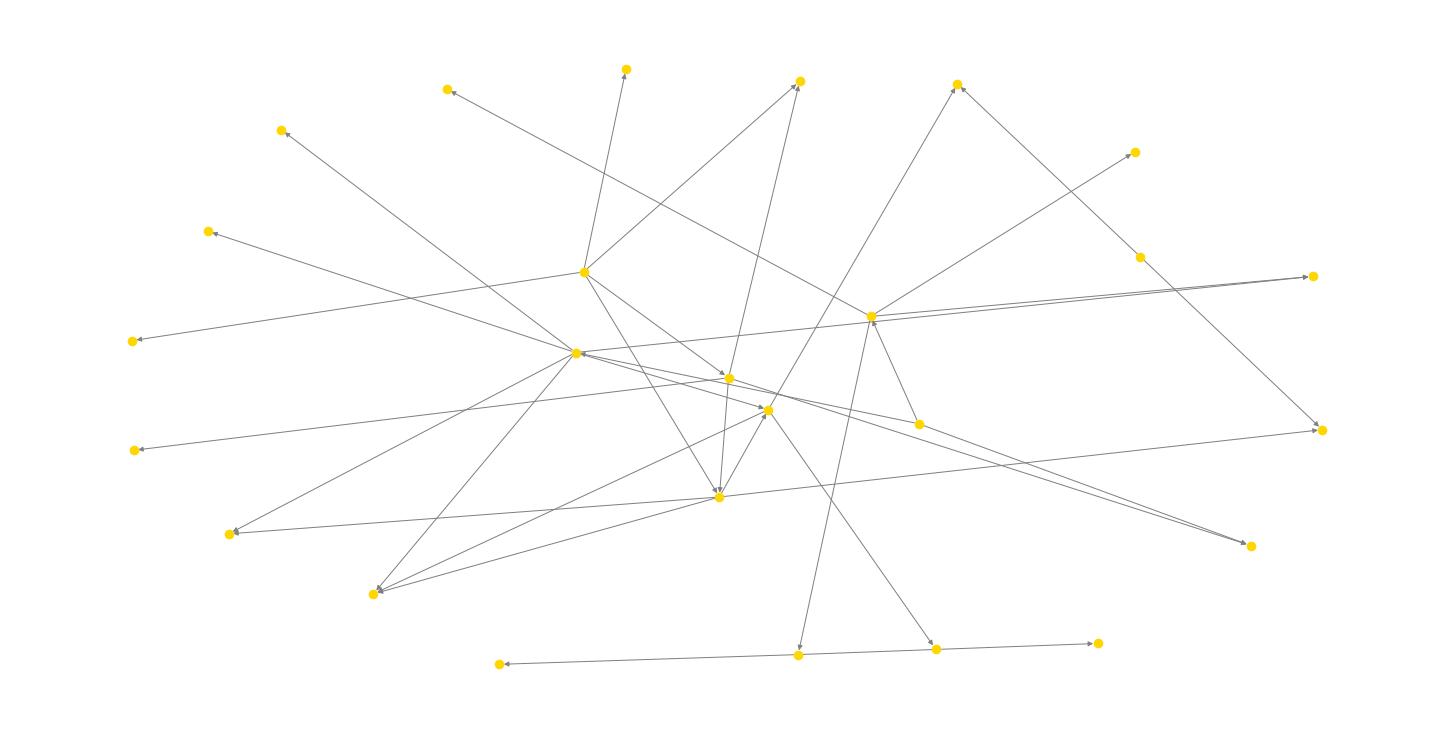

In [ ]:
#just for illustrative purposes
plt.figure(figsize=(20, 10))

G = nx.from_pandas_edgelist(df=new_admins_2003, source='source', target='target', edge_attr='vote', create_using=nx.MultiDiGraph())

nx.draw(G, node_size=75, node_color="gold", edge_color='grey')

##### Louvain algorithm

In [ ]:
G = nx.from_pandas_edgelist(df=new_admins_2003, source='source', target='target', edge_attr='vote', create_using=nx.Graph())

lst_m = community_louvain.best_partition(G)

In [ ]:
community_louvain.best_partition(G)

{'Ark30inf': 0,
 'Arwel Parry': 1,
 'Bcorr': 2,
 'Daniel Quinlan': 0,
 'DavidLevinson': 3,
 'Dieter Simon': 2,
 'Dysprosia': 4,
 'Evercat': 1,
 'Evil saltine': 4,
 'Finlay McWalter': 1,
 'Fuzheado': 1,
 'Ihcoyc': 2,
 'Jwrosenzweig': 0,
 'Michael Hardy': 3,
 'Morwen': 4,
 'Muriel Gottrop': 4,
 'Pakaran': 1,
 'Pratyeka': 0,
 'Secretlondon': 3,
 'SimonP': 1,
 'Snoyes': 3,
 'Stan Shebs': 3,
 'Sugarfish': 0,
 'Timwi': 1,
 'Tristanb': 0,
 'Vancouverguy': 3}

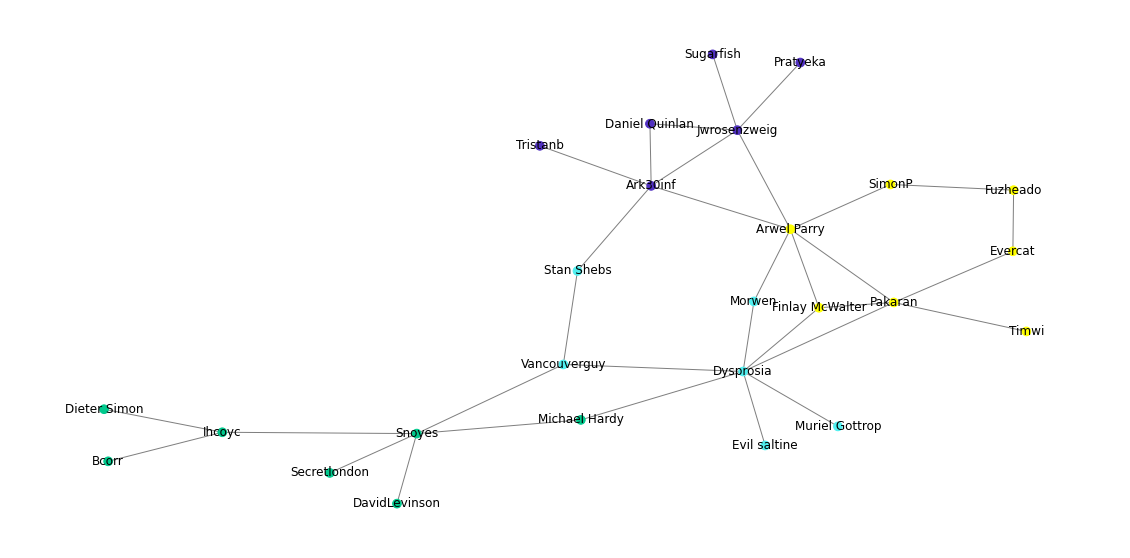

In [ ]:
plt.figure(figsize=(20, 10))

pos = nx.spring_layout(G)

colors = ["#00C98D", "#5030C0", "#50F0F0", "yellow", "#00C98A", "#5030C0", "#50F0F0", "green", "red"]
color_map_b = {}
keys = G.nodes()
values = "black"

for i in keys:
        color_map_b[i] = values

for n in dict(lst_m):
  color_map_b[n] = colors[lst_m[n]]

nx.draw_networkx_edges(G, pos, edge_color="grey")
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values(), node_size=75)
nx.draw_networkx_labels(G, pos)

plt.axis("off")
plt.show()

##### Girvan-Newman algorithm

In [ ]:
G_dir = nx.from_pandas_edgelist(df=new_admins_2003, source='source', target='target', edge_attr='vote', create_using=nx.MultiDiGraph())

In [ ]:
lst_b = nx.algorithms.community.girvan_newman(G_dir)
type(lst_b)

generator

1


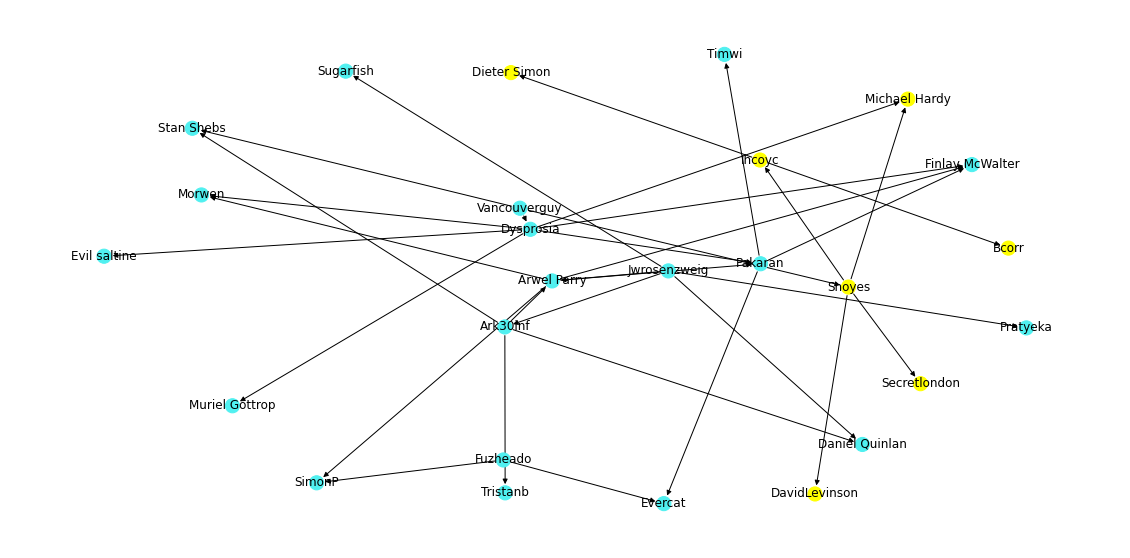

In [ ]:
#Community visualization
plt.figure(figsize=(20, 10))

colors = ["#50F0F0", "yellow"]
pos = nx.spring_layout(G_dir)

lst_b = nx.algorithms.community.girvan_newman(G_dir)

color_map_b = {}
keys = G_dir.nodes()
values = "black"

for i in keys:
        color_map_b[i] = values
counter = 0
for x in lst_b:
  print(1)
  for c in x:
    for n in c:
      #print(n, counter)
      color_map_b[n] = colors[counter]
    counter = counter + 1
  break

nx.draw_networkx_edges(G_dir, pos)
nx.draw_networkx_nodes(G_dir, pos, node_color=dict(color_map_b).values(), node_size=200)
nx.draw_networkx_labels(G_dir, pos, font_size=12)

plt.axis("off")
plt.show()

##### Modularity

In [ ]:
#Modularity for different communities
modularity = []
for x in lst_b:
  modularity.append(nx.algorithms.community.modularity(G_dir, x))
  
modularity

[0.48209366391184577,
 0.4986225895316805,
 0.4820936639118457,
 0.47199265381083566,
 0.45179063360881544,
 0.43434343434343436,
 0.4132231404958677,
 0.386593204775023,
 0.3617998163452709,
 0.33792470156106524,
 0.3122130394857668,
 0.28374655647382924,
 0.26078971533516987,
 0.24150596877869604,
 0.21487603305785125,
 0.18916437098255282,
 0.16253443526170802,
 0.1258034894398531,
 0.09733700642791553,
 0.0707070707070707,
 0.04591368227731864,
 0.021120293847566574,
 -0.000918273645546374,
 -0.027548209366391185]

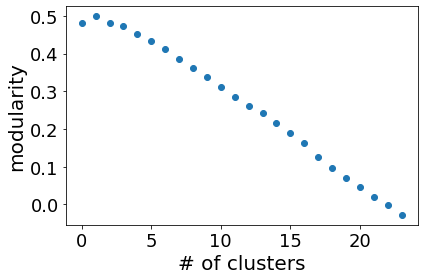

In [ ]:
#Plot modularity
plt.plot(modularity, 'o')
plt.xlabel('# of clusters',fontsize=20)
plt.ylabel('modularity',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
#Extract the community with maximum modularity
index = modularity.index(max(modularity))
lst_b = nx.algorithms.community.girvan_newman(G_dir)

i=0
for v in lst_b:
  if i==index:
    temp = v
  i+=1

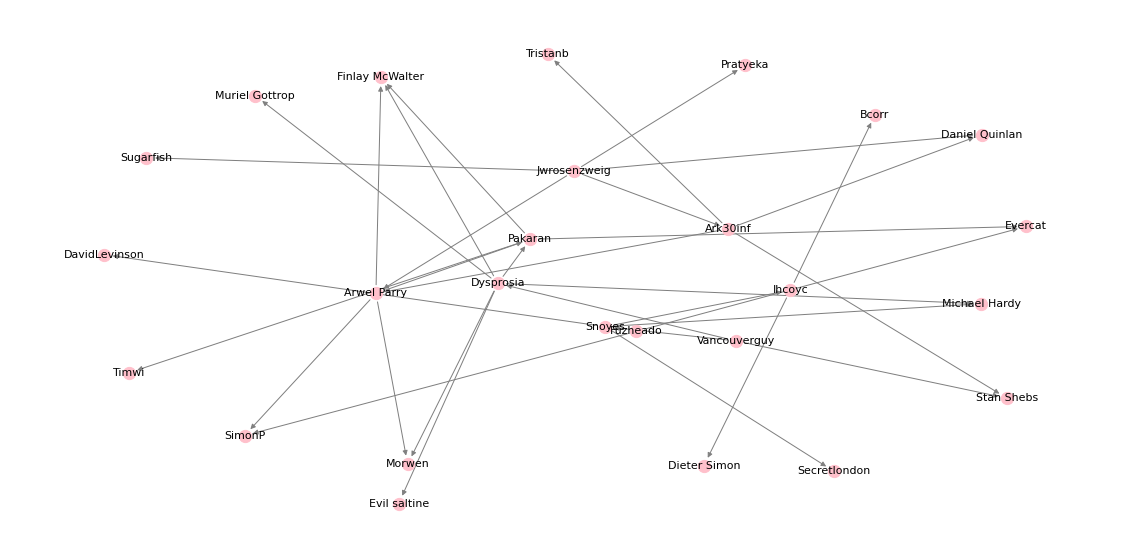

In [ ]:
#Community visualization (the community with maximum modularity)
plt.figure(figsize=(20, 10))

pos = nx.spring_layout(G_dir)
keys = G_dir.nodes()

nx.draw_networkx_edges(G_dir, pos, edge_color="grey")
nx.draw_networkx_nodes(G_dir, pos, node_size=150, node_color="pink")
nx.draw_networkx_labels(G_dir, pos, font_size=11)

plt.axis("off")
plt.show()

#### **Voter's role prediction: new admins and unsuccessful candidates** (Graph Convolution Network):

In [ ]:
admin_data = all_admin_votes[all_admin_votes['date_voting'] >= all_admin_votes['date_admin']]   #all the votes that new admins have given after becoming an admin
other_data = wikipedia_data[wikipedia_data['source'].isin(list(unsuccessful_cand))]   #all the votes that unsuccessful candidates have given

In [ ]:
admin_data = admin_data.assign(role=1)
other_data = other_data.assign(role= 2)

In [ ]:
admin_data = admin_data.drop(columns=['date_orig', 'comment', 'year_admin', 'date_admin'])
admin_data = admin_data.rename(columns={"year_voting": "year", "date_voting": "date"})

In [ ]:
other_data = other_data.drop(columns=['date_orig', 'comment'])

In [ ]:
admin_data

,source,target,vote,result,year,date,role
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,1
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,1
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,1
7,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,1
9,Someguy1221,BDD,1,1,2013,2013-04-20 03:09:00,1
...,...,...,...,...,...,...,...
184512,Vancouverguy,Stan Shebs,1,1,2003,2003-10-02 03:51:00,1
184513,Ark30inf,Stan Shebs,1,1,2003,2003-10-02 03:54:00,1
184516,Jwrosenzweig,Sugarfish,1,1,2003,2003-09-18 04:49:00,1
184520,Pakaran,Timwi,1,1,2003,2003-12-11 21:59:00,1


In [ ]:
other_data

,source,target,vote,result,year,date,role
5,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,2
8,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,2
15,Hahc21,BDD,1,1,2013,2013-04-20 04:49:00,2
34,Marcus Qwertyus,BDD,1,1,2013,2013-04-20 23:02:00,2
35,Dirtlawyer1,BDD,1,1,2013,2013-04-20 23:40:00,2
...,...,...,...,...,...,...,...
184369,Ed Poor,Arwel Parry,1,1,2003,2003-10-10 14:21:00,2
184376,Ed Poor,Bcorr,1,1,2003,2003-12-10 21:41:00,2
184386,Ed Poor,Christopher Mahan,1,1,2003,NaT,2
184481,Ed Poor,Pakaran,1,1,2003,2003-12-05 15:48:00,2


In [ ]:
voting_data = admin_data.append(other_data, ignore_index=True)

In [ ]:
voting_data = voting_data.sort_values(by=['source', 'result'])

In [ ]:
voting_data

,source,target,vote,result,year,date,role
24400,(aeropagitica),PeeJay2K3,-1,-1,2008,2007-05-05 13:21:00,1
34051,(aeropagitica),A Raider Like Indiana,-1,-1,2007,2007-07-31 02:05:00,1
34087,(aeropagitica),ACBest,-1,-1,2007,2007-07-28 20:12:00,1
34207,(aeropagitica),Anthony cfc,1,-1,2007,2007-02-08 23:04:00,1
34241,(aeropagitica),Averross,-1,-1,2007,2007-01-10 17:21:00,1
...,...,...,...,...,...,...,...
60846,Σ,Sadads,-1,1,2011,2011-05-18 05:47:00,2
60932,Σ,Swarm,1,1,2011,2011-10-15 07:44:00,2
60941,Σ,The Blade of the Northern Lights,1,1,2011,2011-11-29 00:34:00,2
60978,Σ,TParis,1,1,2011,2011-06-09 19:16:00,2


In [ ]:
unlabelled_data = voting_data[['source', 'target', 'vote', 'result', 'year', 'date']]

In [ ]:
unlabelled_data = unlabelled_data.rename(columns={"source": "source_orig", "target": "target_orig", 'vote': 'weight'})

In [ ]:
unlabelled_data

,source_orig,target_orig,weight,result,year,date
24400,(aeropagitica),PeeJay2K3,-1,-1,2008,2007-05-05 13:21:00
34051,(aeropagitica),A Raider Like Indiana,-1,-1,2007,2007-07-31 02:05:00
34087,(aeropagitica),ACBest,-1,-1,2007,2007-07-28 20:12:00
34207,(aeropagitica),Anthony cfc,1,-1,2007,2007-02-08 23:04:00
34241,(aeropagitica),Averross,-1,-1,2007,2007-01-10 17:21:00
...,...,...,...,...,...,...
60846,Σ,Sadads,-1,1,2011,2011-05-18 05:47:00
60932,Σ,Swarm,1,1,2011,2011-10-15 07:44:00
60941,Σ,The Blade of the Northern Lights,1,1,2011,2011-11-29 00:34:00
60978,Σ,TParis,1,1,2011,2011-06-09 19:16:00


In [ ]:
users = list(set(unlabelled_data['source_orig']).union(set(unlabelled_data['target_orig'])))

In [ ]:
len(users)

3413

In [ ]:
le = LabelEncoder().fit(users)

In [ ]:
len(list(le.classes_))

3413

In [ ]:
unlabelled_data['source'] = le.transform(unlabelled_data['source_orig'])
unlabelled_data['target'] = le.transform(unlabelled_data['target_orig'])

In [ ]:
unlabelled_data = unlabelled_data.drop(columns=['source_orig', 'target_orig'])

In [ ]:
unlabelled_data

,weight,result,year,date,source,target
24400,-1,-1,2008,2007-05-05 13:21:00,0,2242
34051,-1,-1,2007,2007-07-31 02:05:00,0,19
34087,-1,-1,2007,2007-07-28 20:12:00,0,28
34207,1,-1,2007,2007-02-08 23:04:00,0,195
34241,-1,-1,2007,2007-01-10 17:21:00,0,248
...,...,...,...,...,...,...
60846,-1,1,2011,2011-05-18 05:47:00,3411,2563
60932,1,1,2011,2011-10-15 07:44:00,3411,2833
60941,1,1,2011,2011-11-29 00:34:00,3411,2907
60978,1,1,2011,2011-06-09 19:16:00,3411,2847


In [ ]:
nodes = pd.DataFrame({'user': le.transform(users)})

In [ ]:
G = StellarDiGraph({"source": nodes}, {"target": unlabelled_data})

In [ ]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 3413, Edges: 83368

 Node types:
  source: [3413]
    Features: float32 vector, length 1
    Edge types: source-target->source

 Edge types:
    source-target->source: [83368]
        Weights: range=[-1, 1], mean=0.565805, std=0.824544
        Features: float32 vector, length 3


In [ ]:
labels = voting_data[['source', 'role']]

In [ ]:
labels['id'] = le.transform(labels['source'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
labels = labels.drop(columns='source')

In [ ]:
labels.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [ ]:
labels.set_index('id', drop=True, inplace=True)

In [ ]:
labels = labels.squeeze()

In [ ]:
labels

id
0       1
2       2
3       2
5       1
6       1
       ..
3394    1
3395    2
3399    1
3401    2
3411    2
Name: role, Length: 2358, dtype: int64

In [ ]:
labels.value_counts().to_frame()

,role
1,1553
2,805


##### Incomplete try to balance the dataset

In [ ]:
unlabelled_data_array = unlabelled_data.to_numpy()

In [ ]:
unlabelled_data_array.shape

(83368, 6)

In [ ]:
roles = voting_data['role']

In [ ]:
roles.shape

(83368,)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

#fit predictor and target variable
data_res, roles_res = ros.fit_resample(unlabelled_data_array, roles)

print('Original dataset shape %s' % Counter(roles))
print('Resampled dataset shape %s' % Counter(roles_res))

Original dataset shape Counter({1: 59311, 2: 24057})
Resampled dataset shape Counter({1: 59311, 2: 59311})


In [ ]:
data_resampled = pd.DataFrame(data_res, columns=unlabelled_data.columns)

In [ ]:
data_resampled.shape

(118622, 6)

In [ ]:
data_resampled.head()

,weight,result,year,date,source,target
0,-1,-1,2008,2007-05-05 13:21:00,0,2242
1,-1,-1,2007,2007-07-31 02:05:00,0,19
2,-1,-1,2007,2007-07-28 20:12:00,0,28
3,1,-1,2007,2007-02-08 23:04:00,0,195
4,-1,-1,2007,2007-01-10 17:21:00,0,248


In [ ]:
roles

24400    1
34051    1
34087    1
34207    1
34241    1
        ..
60846    2
60932    2
60941    2
60978    2
61021    2
Name: role, Length: 83368, dtype: int64

##### ... the chapter continues with unbalanced data

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    labels, train_size=200, test_size=None, stratify=labels)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects)

print(train_subjects.shape, val_subjects.shape, test_subjects.shape)

(200,) (500,) (1658,)


In [ ]:
train_subjects.value_counts().to_frame()  #the training set has class imbalance that needs to be compensated

,role
1,132
2,68


In [ ]:
train_subjects.head()

id
2228    1
778     2
705     1
2035    2
576     1
Name: role, dtype: int64

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
train_targets.shape

(200, 1)

In [ ]:
train_targets[0:10]

array([[0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0]])

In [ ]:
# classWeights = compute_class_weight(class_weight='balanced', classes=np.unique(train_targets), y=train_targets.flatten())
# classWeights = dict(zip(np.unique(train_targets), classWeights))
# classWeights

In [ ]:
# sampleWeights = compute_class_weight(class_weight='balanced', classes=np.unique(train_targets), y=train_targets.flatten())
# sampleWeights

In [ ]:
# sampleWeights = train_targets.copy()
# sampleWeights = np.where(sampleWeights==0, 0.75757576, 1.47058824)

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn", weighted=True)

Using GCN (local pooling) filters...


/usr/local/lib/python3.7/dist-packages/stellargraph/core/utils.py:131: RuntimeWarning: divide by zero encountered in power
  d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.binary_crossentropy,
    metrics=["acc"]
)

In [ ]:
# sampleWeights = compute_class_weight(class_weight='balanced', classes=np.unique(val_targets), y=val_targets.flatten())
# sampleWeights

In [ ]:
# sampleWeights = val_targets.copy()
# sampleWeights = np.where(sampleWeights==0, 0.75987842, 1.4619883)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,
    callbacks=[es_callback]
)

Epoch 1/200
1/1 - 1s - loss: nan - acc: 0.3600 - val_loss: nan - val_acc: 0.6580 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 74ms/epoch - 74ms/step
Epoch 3/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 70ms/epoch - 70ms/step
Epoch 4/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 101ms/epoch - 101ms/step
Epoch 5/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 78ms/epoch - 78ms/step
Epoch 6/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 83ms/epoch - 83ms/step
Epoch 7/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 74ms/epoch - 74ms/step
Epoch 8/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 77ms/epoch - 77ms/step
Epoch 9/200
1/1 - 0s - loss: nan - acc: 0.6600 - val_loss: nan - val_acc: 0.6580 - 74ms/epoch - 74ms/step
Epoch 10/200
1/1 - 0s - loss: nan - acc: 0.6600 

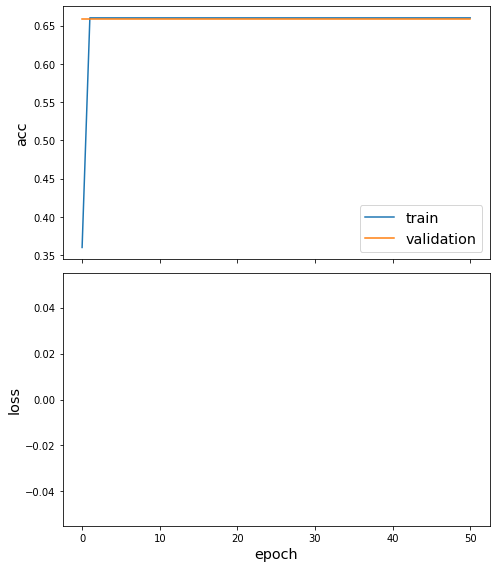

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 51ms/step - loss: nan - acc: 0.6586

Test Set Metrics:
	loss: nan
	acc: 0.6586


In [ ]:
all_labels = labels.index
all_gen = generator.flow(all_labels)
all_predictions = model.predict(all_gen)

In [ ]:
label_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
comparison = pd.DataFrame({"Predicted": label_predictions, "True": labels})
comparison.head(10)

,Predicted,True
id,,
0,1,1
2,1,2
3,1,2
5,1,1
6,1,1
8,1,1
9,1,1
11,1,1
15,1,2


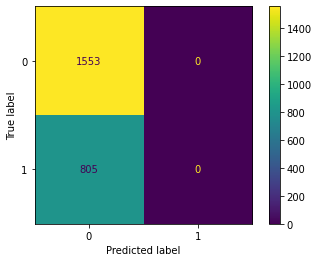

In [ ]:
conf_matrix = confusion_matrix(labels, label_predictions)

conf_m_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_m_plot.plot()
plt.show()

#### **Voter's role prediction: new admins and unsuccessful candidates** (GraphSAGE):

Previous steps are done under GCN task

In [ ]:
labels_sampled = labels.sample(frac=0.8, replace=False, random_state=101)

In [ ]:
len(labels_sampled)

1886

In [ ]:
labels_sampled.index

Int64Index([2678, 1886, 1656, 1327, 1526, 1294, 1585,  852, 2906, 1291,
            ...
            2431,  212,   95, 2789,  386, 2548, 3128, 2820, 1831, 1351],
           dtype='int64', name='id', length=1886)

In [ ]:
graph_sampled = G.subgraph(labels_sampled.index)   #giving the selected 80% of the node ID-s to form subgraph

In [ ]:
print(graph_sampled.info())

StellarDiGraph: Directed multigraph
 Nodes: 1886, Edges: 43989

 Node types:
  source: [1886]
    Features: float32 vector, length 1
    Edge types: source-target->source

 Edge types:
    source-target->source: [43989]
        Weights: range=[-1, 1], mean=0.613267, std=0.789885
        Features: none


In [ ]:
train_labels, test_labels = model_selection.train_test_split(
    labels_sampled,
    train_size=0.05,
    test_size=None,
    stratify=labels_sampled,
    random_state=42,
)

In [ ]:
test_labels.shape

(1792,)

In [ ]:
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=0.2, test_size=None, stratify=test_labels, random_state=100,
)

In [ ]:
test_labels.shape

(1434,)

In [ ]:
Counter(train_labels)   #imbalanced dataset

Counter({1: 62, 2: 32})

In [ ]:
train_labels

id
3246    1
1828    1
294     1
2985    2
2834    1
       ..
319     1
1392    1
2141    1
982     1
414     1
Name: role, Length: 94, dtype: int64

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

In [ ]:
target_encoding.classes_

array([1, 2])

In [ ]:
train_targets[0:10]

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]])

In [ ]:
batch_size = 50
num_samples = [10, 10]

In [ ]:
generator = GraphSAGENodeGenerator(graph_sampled, batch_size, num_samples)

In [ ]:
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)

In [ ]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5
)

In [ ]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

In [ ]:
prediction.shape

TensorShape([None, 1])

In [ ]:
type(prediction)

keras.engine.keras_tensor.KerasTensor

In [ ]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"]
)

In [ ]:
val_gen = generator.flow(val_labels.index, val_targets)

In [ ]:
history = model.fit(
    train_gen, epochs=15, validation_data=val_gen, verbose=1, shuffle=False
)

Epoch 1/15
2/2 [==============================] - 2s 715ms/step - loss: 0.7228 - acc: 0.3723 - val_loss: 0.6892 - val_acc: 0.5670
Epoch 2/15
2/2 [==============================] - 0s 301ms/step - loss: 0.6861 - acc: 0.5745 - val_loss: 0.6598 - val_acc: 0.6564
Epoch 3/15
2/2 [==============================] - 0s 370ms/step - loss: 0.6708 - acc: 0.6596 - val_loss: 0.6473 - val_acc: 0.6564
Epoch 4/15
2/2 [==============================] - 0s 325ms/step - loss: 0.6552 - acc: 0.6596 - val_loss: 0.6446 - val_acc: 0.6564
Epoch 5/15
2/2 [==============================] - 0s 313ms/step - loss: 0.6436 - acc: 0.6596 - val_loss: 0.6481 - val_acc: 0.6564
Epoch 6/15
2/2 [==============================] - 0s 291ms/step - loss: 0.6360 - acc: 0.6596 - val_loss: 0.6521 - val_acc: 0.6564
Epoch 7/15
2/2 [==============================] - 0s 364ms/step - loss: 0.6391 - acc: 0.6596 - val_loss: 0.6563 - val_acc: 0.6564
Epoch 8/15
2/2 [==============================] - 0s 365ms/step - loss: 0.6463 - acc: 0.65

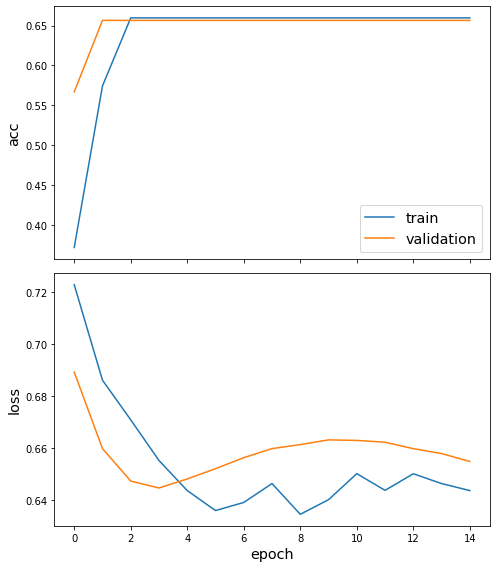

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_labels.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

29/29 [==============================] - 1s 40ms/step - loss: 0.6534 - acc: 0.6576

Test Set Metrics:
	loss: 0.6534
	acc: 0.6576


In [ ]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [ ]:
hold_out_nodes = labels.index.difference(labels_sampled.index)
labels_hold_out = labels[hold_out_nodes]

In [ ]:
len(hold_out_nodes)

472

In [ ]:
hold_out_targets = target_encoding.transform(labels_hold_out)

In [ ]:
hold_out_gen = generator.flow(hold_out_nodes, hold_out_targets)

In [ ]:
hold_out_predictions = model.predict(hold_out_gen)

In [ ]:
hold_out_predictions = target_encoding.inverse_transform(hold_out_predictions)

In [ ]:
len(hold_out_predictions)

472

In [ ]:
results = pd.Series(hold_out_predictions, index=hold_out_nodes)
df = pd.DataFrame({"Predicted": results, "True": labels_hold_out})
df.head(10)

,Predicted,True
id,,
2,1,2
5,1,1
17,1,2
18,1,1
25,1,1
33,1,1
56,1,1
63,1,1
64,1,1


In [ ]:
hold_out_metrics = model.evaluate(hold_out_gen)
print("\nHold Out Set Metrics:")
for name, val in zip(model.metrics_names, hold_out_metrics):
    print("\t{}: {:0.4f}".format(name, val))

10/10 [==============================] - 0s 33ms/step - loss: 0.6485 - acc: 0.6631

Hold Out Set Metrics:
	loss: 0.6485
	acc: 0.6631


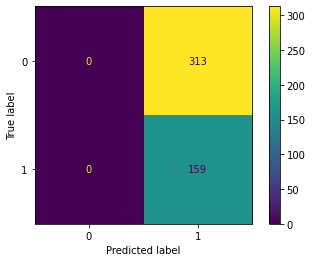

In [ ]:
conf_matrix = confusion_matrix(hold_out_targets, hold_out_predictions)

conf_m_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_m_plot.plot()
plt.show()